# Сначала переводим изображение в бинарное

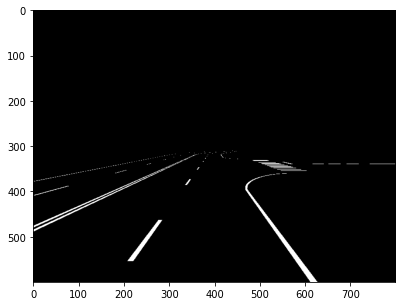

In [160]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

destination = "all"
img_primal = cv2.imread(os.path.join(destination,str(1) + ".png"))
img_primal = (img_primal.sum(axis = 2) == 441).astype("uint8") * 255
plt.imshow(img_primal,cmap ="gray") # Show results
plt.show()

# Bird view преобразование, по факту сужаем нижнюю часть

In [161]:
plt.rcParams["figure.figsize"] = (30,5)

IMAGE_H = 600
IMAGE_dH = int(IMAGE_H *2/4 + 50) 
IMAGE_H = IMAGE_H - IMAGE_dH 
IMAGE_W = 800

PARAMETERS ={
    "cost" : 10,
    "kernel":(3, 3),
    "max_dy": 10,
    "max_slices": 20,
    "min_line_len": 100,
    "sigma_coef": 0.8,
    "bottom_margin_for_classification": 25
}
CLASSES = {
    "isDash": 1,
    "isLine": 2,
    "isDoubleLine": 3,
    "isNone": 10
}


In [162]:
def birdView(img_rimal,plot = False):
    img = img_primal[IMAGE_dH:-1, 0:-1]
    src = np.float32([[0,0],[IMAGE_W,0],[400+80,IMAGE_H],[400 - 80, IMAGE_H]]) 
    dst = np.float32([[0, 0],[IMAGE_W, 0], [IMAGE_W, IMAGE_H],[0,IMAGE_H]])

    #for point in src:
    #    point = np.int32(point)
    #    img = cv2.circle(img,point,20,(0,255,0),thickness=-1)

    #for point in dst:
    #    point = np.int32(point)
    #    img = cv2.circle(img,point,10,(0,0,255),thickness=-1)

    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation
    warped_img = cv2.warpPerspective(img, Minv, (IMAGE_W, IMAGE_H)) # Image warping

    kernel = np.ones(PARAMETERS["kernel"], 'uint8')
    warped_img = cv2.dilate(warped_img, kernel, iterations=1)
    
    if plot:
        plt.imshow(img,cmap ='gray') # Show results
        plt.show()

        plt.imshow(warped_img,cmap ='gray') # Show results
        plt.show()
    return warped_img,img, M, Minv

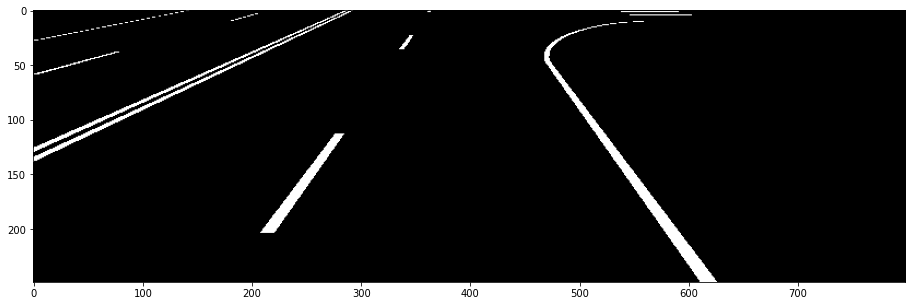

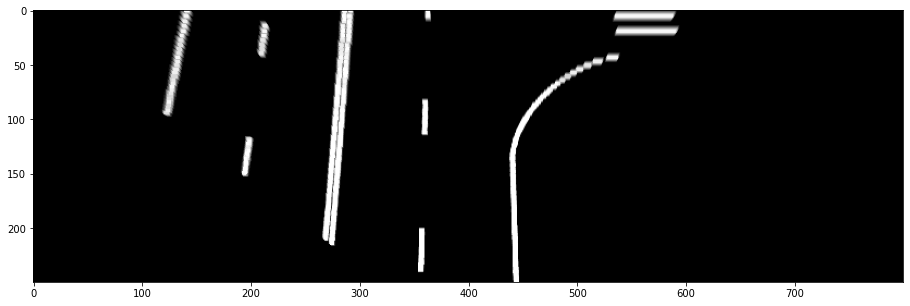

In [163]:
warped_img, img, M, Minv = birdView(img_primal,True)

# Применяем метод связных компонент 

In [164]:
CCWS = cv2.connectedComponentsWithStats(warped_img)
#(numLabels, labels, stats, centroids) = CCWS

# Полученные сегменты:
## * Фильтруем по площади, убирая откровенно мелкие детали
## * Выделяем 2 точки у вершины сегмента, в дальнейшем "голова"
## TO DO выделить и хвосты + Проверять на выход за пределы изображения

In [165]:
def getMeanXpoint(img,x,y,w,index = 255):
    res, = np.where(img[y, x : x + w] == index)
    res = res + x
    if(len(res) == 0):
        return None,None,None
    else:
        return int(np.mean(res)), min(res), max(res) 

def pointHeadAndTail(CCWS,plot = False):
    (numLabels, labels, stats, centroids) = CCWS
    labels_index = list();
    segment_points =dict();
    for i in range(1,numLabels):    

        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]


        #ПРОВЕРИТЬ ПРОВЕРИТЬ ПРОВЕРИТЬ проверку
        if h >= 7: ## тут удаляем малые обьекты h >= y_shift + max(h_segment) 

            y_shift = max(2,int(0.05 * h))
            h_segment = min(int(0.2 * h),5)

            y_head_top = y + y_shift
            y_head_bot = y + h_segment + y_shift

            x_head_top_mean = getMeanXpoint(labels,x,y_head_top,w,i)[0]
            x_head_bot_mean = getMeanXpoint(labels,x,y_head_bot,w,i)[0]

            y_tail_top = y + h - h_segment - y_shift
            y_tail_bot = y + h - y_shift

            x_tail_top_mean = getMeanXpoint(labels,x,y_tail_top,w,i)[0]
            x_tail_bot_mean = getMeanXpoint(labels,x,y_tail_bot,w,i)[0]

            segment_points[i]  = (x_head_top_mean, y_head_top, x_head_bot_mean, y_head_bot,
                                 x_tail_top_mean, y_tail_top, x_tail_bot_mean, y_tail_bot)
            labels_index.append(i)

            # тут проверка, но кажется изза метода связных компонент она излишня
            #if(x_head_top_mean != None) & (x_head_bot_mean != None) & (x_tail_top_mean != None) & (x_tail_bot_mean != None):
            #    segment_points[i]  = (x_head_top_mean, y_head_top, x_head_bot_mean, y_head_bot)
            #    labels_index.append(i)

    if(plot):
        ###printing
        componentMask = np.zeros((IMAGE_H,IMAGE_W),dtype = "uint8")
        for i in labels_index:
            componentMask += (labels == i).astype("uint8") * 255
            
        plt.imshow(componentMask)
        for i in labels_index:
            x0,y0,x1,y1,x2,y2,x3,y3 = segment_points[i]
            plt.plot(x0,y0, color='blue', marker='o',markersize = 3)
            plt.plot(x1,y1, color='red', marker='o',markersize = 3)
            plt.plot(x2,y2, color='blue', marker='o',markersize = 3)
            plt.plot(x3,y3, color='red', marker='o',markersize = 3)
        plt.show()
    return labels_index, segment_points

def pointHeadAndTail2(CCWS,labels_index,segments_Linepoints,plot=False):
    (numLabels, labels, stats, centroids) = CCWS
    
    segment_points = dict()
    for index in labels_index:
        points = segments_Linepoints[index]
        segment_points[index] = [points[0][0],points[0][1],points[1][0],points[1][1],
                                 points[-2][0],points[-2][1],points[-1][0],points[-1][1]]
        
        
    if(plot):
        ###printing
        componentMask = np.zeros((IMAGE_H,IMAGE_W),dtype = "uint8")
        for i in labels_index:
            componentMask += (labels == i).astype("uint8") * 255
            
        plt.imshow(componentMask)
        for i in labels_index:
            x0,y0,x1,y1,x2,y2,x3,y3 = segment_points[i]
            plt.plot(x0,y0, color='blue', marker='o',markersize = 3)
            plt.plot(x1,y1, color='red', marker='o',markersize = 3)
            plt.plot(x2,y2, color='blue', marker='o',markersize = 3)
            plt.plot(x3,y3, color='red', marker='o',markersize = 3)
        plt.show() 
    
    return (segment_points)

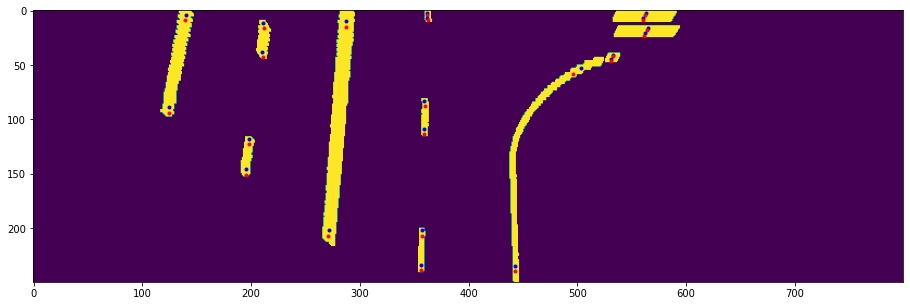

{1: (140, 4, 139, 9, 124, 89, 124, 94),
 2: (287, 10, 287, 15, 272, 202, 271, 207),
 3: (362, 2, 362, 4, 362, 7, 363, 9),
 4: (563, 2, 562, 4, 560, 7, 560, 9),
 5: (211, 11, 212, 16, 210, 38, 211, 43),
 6: (565, 16, 564, 18, 562, 21, 561, 23),
 7: (533, 41, 533, 42, 531, 45, 531, 46),
 8: (503, 53, 496, 58, 443, 235, 443, 240),
 9: (359, 83, 360, 88, 359, 109, 359, 114),
 10: (198, 118, 198, 123, 195, 146, 195, 151),
 11: (357, 202, 357, 207, 356, 234, 356, 239)}

In [166]:
labels_index, segment_points = pointHeadAndTail(CCWS,True)
segment_points

# Находим расстояния от прямых головы до точек хвоста (пока что до головы)
# Находим углы между прямыми головы и хвоста(пока головы)

$$ \frac{x - x_1}{x_2 - x_1} = \frac{y - y_1}{y_2 - y_1}$$
$$ x = y\frac{x_2 - x_1}{y_2 - y_1} - y_1\frac{x_2 - x_1}{y_2 - y_1} + x_1$$
$$ x - y\frac{x_2 - x_1}{y_2 - y_1} + y_1\frac{x_2 - x_1}{y_2 - y_1} - x_1 = 0$$
$$ Ax +By + C = 0 $$
$$ distance(Ax +By+C =0, (x0,y0)) = \frac{|Ax_0 + By_0 + C|}{\sqrt{A^2 + B^2}} $$
Или так, если прямая проходит через 2 точки $$ P_1, P_2 $$
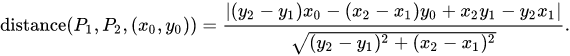

In [167]:

sqrt = np.sqrt
def getDistance2(P1,P2,P0):
    x1,y1 = P1
    x2,y2 = P2
    x0,y0 = P0
    dx = x2 - x1
    dy = y2 - y1
    return abs( dy*x0 - dx*y0 + x2*y1 - y2*x1)/sqrt(dy**2 + dx**2)


def angleBetweenVectors(p1,p2,p3,p4):
    v1 = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    v2 = np.array([p4[0] - p3[0], p4[1] - p3[1]])
    return abs(np.arccos((v1 @ v2) / (np.linalg.norm(v1) *np.linalg.norm(v2))))


def linkSegments(labels_index, segment_points,plot = False):
    labels_count = len(labels_index)
    connected_segments = [set([labels_index[i]]) for i in range(0,labels_count)]
    for i in range(0,labels_count):
        label_index1 = labels_index[i] 
        x1,y1,x2,y2,*v = segment_points[label_index1]
        p1,p2 = (x1,y1),(x2,y2)


        for j in range(0,labels_count):
            if(j != i):
                label_index2 = labels_index[j]
                x_1,y_1,x_2,y_2,x3,y3,x4,y4 = segment_points[label_index2]
                p3,p4 = (x3,y3),(x4,y4)


                d12_3 = getDistance2(p1,p2,p3)
                d12_4 = getDistance2(p1,p2,p4)
                d34_1 = getDistance2(p3,p4,p1)
                d34_2 = getDistance2(p3,p4,p2)
                dist_g = [d12_3,d12_4,d34_1,d34_2]

                dist_r = [None]*4
                dist_r[0] = angleBetweenVectors(p2,p1,p1,p3)
                dist_r[1] = angleBetweenVectors(p2,p1,p1,p4)
                dist_r[2] = angleBetweenVectors(p3,p4,p4,p1)
                dist_r[3] = angleBetweenVectors(p3,p4,p4,p2)


                mean_dir = np.mean(dist_r)
                mean_geo = np.mean([d12_3,d12_4,d34_1,d34_2])
                var_dir = np.var(dist_r)
                var_geo = np.var([d12_3,d12_4,d34_1,d34_2])

                new_dist_r = [(dist_r[k] - mean_dir) / sqrt(var_dir) * sqrt(var_geo) + mean_geo for k in range(0,4) ]
                cost = np.mean([(dist_g[k] + new_dist_r[k])/2 for k in range(0,4)])

            #print(label_index1,label_index2,dist_r, dist_g)


    # соединяем множества номеров сегментов      
                segment_group_index1, segment_group_index2 = 0,0
                if cost < PARAMETERS["cost"]:
                    #print(label_index1,label_index2)
                    for k in range(len(connected_segments)):
                        segment_group = connected_segments[k]

                        if label_index1 in segment_group:
                            segment_group_index1 = k
                        if label_index2 in segment_group:
                            segment_group_index2 = k

                    if(segment_group_index1 != segment_group_index2):
                        connected_segments[segment_group_index1] = connected_segments[segment_group_index1].union(connected_segments[segment_group_index2])
                        connected_segments.pop(segment_group_index2)
                if(plot):
                    print(label_index1,label_index2,cost)
    return connected_segments

In [168]:
connected_segments = linkSegments(labels_index, segment_points)

## Каждый классифицированный сегмент разбиваем на точки для фита
Точки выбираются путем среденго по Х, затем у каждого сегмента удаляются те точки которые лежат за -sigma, что гарантирует что все точки лежат на жирной прямой а не на кончиках сегмента.

In [169]:
# принимает карту, начальная точка (x,y), ширину w, сравниваем все точки с index

def pointMeanPoints(CCWS,labels_index,plot = False):
    (numLabels, labels, stats, centroids) = CCWS
    segments_linePoints = dict()
    
    for index in labels_index:
        segments_linePoints[index] = list()
        x_left = stats[index, cv2.CC_STAT_LEFT]
        y = stats[index, cv2.CC_STAT_TOP]
        w = stats[index, cv2.CC_STAT_WIDTH]
        h = stats[index, cv2.CC_STAT_HEIGHT]


        dy = max(PARAMETERS["max_dy"], h // PARAMETERS["max_slices"])
        dy = min(max((1,h // 4)),dy)
        
        newY = y
        buffer = list()
        while(newY < y + h):
            x_mean, x_min, x_max = getMeanXpoint(labels,x_left,newY,w,index)

            if(x_mean == None):
                continue
            buffer.append(((x_mean,newY),x_max - x_min))
            newY += dy

        line_width = [ line_w for point, line_w in buffer]
        sigma = np.std(line_width)
        mean = np.mean(line_width)
        new_linePoints = list([point for point, line_width in buffer if line_width - mean >= -sigma * PARAMETERS["sigma_coef"]])
        if(len(new_linePoints) >= 2):
            segments_linePoints[index] = new_linePoints
        else:
            segments_linePoints[index] = list([point for point, line_width in buffer])
            
        
#####ploting########################

        #for ploting
    if(plot):
        res = np.zeros((IMAGE_H,IMAGE_W),dtype = "uint8")
        for index in labels_index:
            res += (labels == index).astype("uint8") * 255
        
            for point in segments_linePoints[index]:
                x,y = point
                plt.plot(x,y,marker='o',markersize = 3)
                
        plt.imshow(res,cmap ="gray")
        plt.show()
    return segments_linePoints


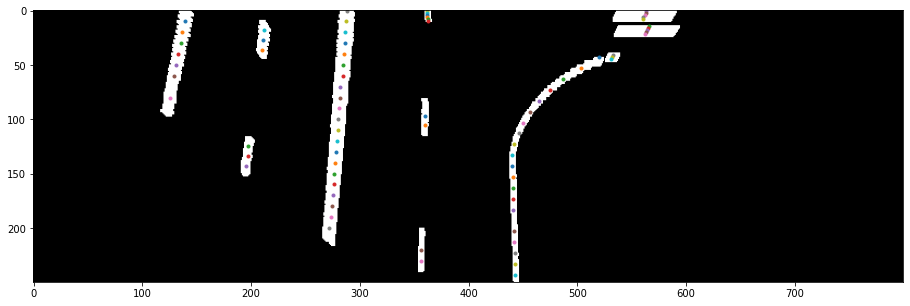

In [170]:
segments_linePoints = pointMeanPoints(CCWS,labels_index,True)
#plt.imshow(warped_img,cmap ='gray') # Show results
#plt.show()

In [171]:
connected_segments

[{1}, {2}, {3, 9, 11}, {4, 6}, {5}, {7}, {8}, {10}]

## Фитинг точек до кривых третьего порядка

In [172]:


def fitLines(CCWS,segments_linePoints,plot = False):
    (numLabels, labels, stats, centroids) = CCWS
    segments_lineCoef = list()
    
    for connected_segment_indexes in connected_segments:    
        #определяем размерность проблемы
        shape_j = 0
        for index in connected_segment_indexes:
            shape_j +=len(segments_linePoints[index])

        A = np.zeros((shape_j,4))
        Y = np.zeros((shape_j,1))# for plotting
        X = np.zeros((shape_j,1))

        # Для каждого связанного сегмента строим матрицу A и X, по точкам
        j = 0
        for index in connected_segment_indexes:
            for i in range(len(segments_linePoints[index])):
                x,y = segments_linePoints[index][i]

                A[j] = [y**3,y**2,y,1]
                Y[j] = y # for plotting
                X[j] = x
                j += 1

        # Фитинг + остаток
        coefs,residual = np.linalg.lstsq(A,X,rcond=-1)[0:2]
        segments_lineCoef.append(coefs)

    ############# for plotting############
        if(plot):
            res = np.zeros(labels.shape,dtype = bool) #for plot
            for index in connected_segment_indexes:
                res = np.logical_or(res,labels == index) #for plot
            linApprox = lambda y: np.array([y**3,y**2,y,1]) @ coefs

            Y_approx = np.linspace(0,IMAGE_H,100,dtype = int)
            X_approx = np.array([linApprox(x) for x in Y[:,0]],dtype = int)
            X_approx2 = np.array([linApprox(x) for x in Y_approx],dtype = int)


            plt.plot(X_approx2,Y_approx)

            print(residual,np.linalg.norm(X - A @ coefs))
            res = res.astype("uint8") * 255
            plt.imshow(res,cmap ="gray")
    if(plot):
        plt.show()

    
    return segments_lineCoef

segments_lineCoef = fitLines(CCWS,segments_linePoints)

## Класиификация по кривым

### Отсев:
1) Вырезаем кривые которые пересекают остальные кривые (раметка параллельная)

2) Оставляем только те линии которые пересекают низ фотографии (разметка начинается снизу)

### Текущие классификации:
1) Все кривые интегрируются в боксе своего сегмента, если длина полученного отрезка больше эталона то это прямая

2) По дефолту все классы это деши

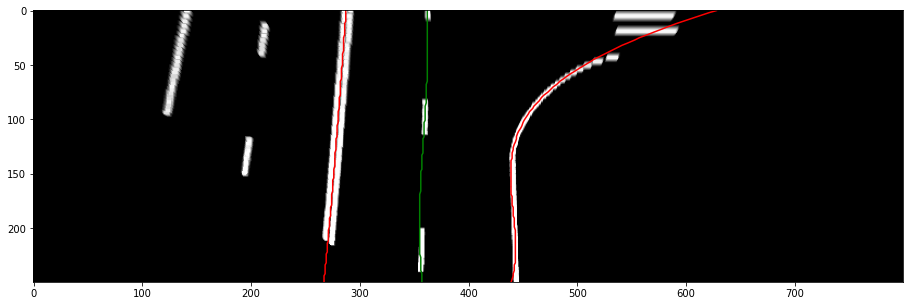

In [173]:
import scipy.integrate as integrate


#return dv - единичную длину кривой 3го порядка (требует интегрирования)
def getLen_of_line(x,coefs):
    a,b,c,d = coefs
    return ((3 * a * x**2 + 2 * b * x + c)**2 + 1)**(1/2)


#классы разметок

def classification(CCWS,connected_segments,segments_lineCoef,plot = False):
    (numLabels, labels, stats, centroids) = CCWS
    #Просто часто используются
    countOfLines = len(connected_segments)
    segments_classification = [CLASSES["isDash"]] * countOfLines

    y0 = 0
    Y_Top = np.array([y0**3,y0**2,y0,1])
    ybot = IMAGE_H - PARAMETERS["bottom_margin_for_classification"]
    Y_Bot = np.array([ybot**3,ybot**2,ybot,1])


    #########Вырезаем тех кто пересекает остальных###############

    segments_intersection = [set() for x in range(countOfLines)]
    for i in range(countOfLines):
        lineCoefs_first = segments_lineCoef[i]
        for j in range(i+1,countOfLines):
            lineCoefs_second = segments_lineCoef[j]

            x1_top = Y_Top @ lineCoefs_first
            x1_bot = Y_Bot @ lineCoefs_first

            x2_top = Y_Top @ lineCoefs_second
            x2_bot = Y_Bot @ lineCoefs_second
    
            if (x1_top < x2_top) ^ (x1_bot < x2_bot): # детектировано пересечение
                segments_intersection[i].add(j)
                segments_intersection[j].add(i)
    
    
    lenOfSets = np.array([ len(intersection_set) for intersection_set in segments_intersection])
    maxCount_intersections = max(lenOfSets)
    
    while maxCount_intersections > 0:

        indexes = np.where(lenOfSets == maxCount_intersections)[0]
        for index in indexes:
            segments_intersection[index] = set()
            segments_classification[index] = CLASSES["isNone"]

        for intersection_set in segments_intersection:
            for index in indexes:
                intersection_set.discard(index)

        lenOfSets = np.array([ len(intersection_set) for intersection_set in segments_intersection])
        maxCount_intersections = max(lenOfSets)

    ###########линия должна начинаться внизу экрана############
    for i in range(countOfLines):
        coefs = segments_lineCoef[i]
        currentType = segments_classification[i]



        Y = np.array([ybot**3, ybot**2, ybot, 1])
        x = Y @ coefs
        if (x < 0) | (IMAGE_W < x):
            currentType = max(currentType,CLASSES["isNone"])
            segments_classification[i] = currentType

    ##########после отсева классифицируем##########
    for i in range(countOfLines):
        coefs = segments_lineCoef[i]
        connected_segment_indexes = connected_segments[i]
        currentType = segments_classification[i]

        if(currentType != CLASSES["isNone"]):
            for index in connected_segment_indexes:

                #длина линии в прямоугольнике сегмента, в классе прямой должен быть длинный сегмент
                y = stats[index, cv2.CC_STAT_TOP]
                h = stats[index, cv2.CC_STAT_HEIGHT]

                integral = abs(integrate.quad(lambda x: getLen_of_line(x,coefs), y, y+h,limit = 10)[0])

                if(integral > PARAMETERS["min_line_len"]):
                    currentType = max(currentType,CLASSES["isLine"])
                #print(index,integral)    
        segments_classification[i] = currentType
        
    if(plot):
        for classification, coefs in zip(segments_classification,segments_lineCoef):
            if(classification != CLASSES["isNone"]):
                linApprox = lambda y: np.array([y**3,y**2,y,1]) @ coefs
                Y_approx = np.linspace(0,IMAGE_H,100,dtype = int)    
                X_approx = np.array([linApprox(x) for x in Y_approx],dtype = int)
                color = 'green' if(classification == CLASSES["isDash"]) else "red" 
                plt.plot(X_approx,Y_approx,color =color)
        plt.imshow(warped_img,cmap ='gray') # Show results
        plt.show()
        
    return segments_classification
segments_classification = classification(CCWS,connected_segments,segments_lineCoef,True)

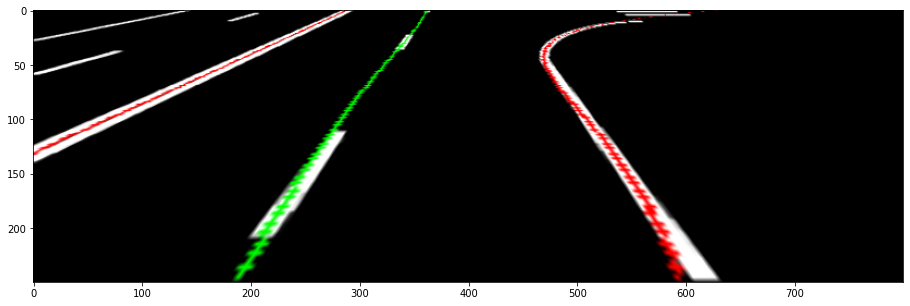

In [174]:
def turnPerspective(warped_img,segments_classification,segments_lineCoef,M,plot = False):
    backtorgb = cv2.cvtColor(warped_img,cv2.COLOR_GRAY2RGB)

    for classification, coefs in zip(segments_classification,segments_lineCoef):
        if(classification != CLASSES["isNone"]):
            
            Y_approx = np.linspace(0,IMAGE_H,100,dtype = int)    
            X_approx = np.array([np.array([y**3,y**2,y,1]) @ coefs for y in Y_approx],dtype = int)
            
            color1 = (0,255,0) if(classification == CLASSES["isDash"]) else (255,0,0) 

            for x,y in zip(X_approx,Y_approx):
                x = x[0]
                if(0 < x & x < IMAGE_W):
                    cv2.circle(backtorgb, (x,y), radius=1, color=color1,thickness=-1)
    final_img = cv2.warpPerspective(backtorgb, M, (IMAGE_W, IMAGE_H)) # Image warping
    plt.imshow(final_img)
    plt.show()
    
turnPerspective(warped_img,segments_classification,segments_lineCoef,M,True)

##############Pitcute№___589


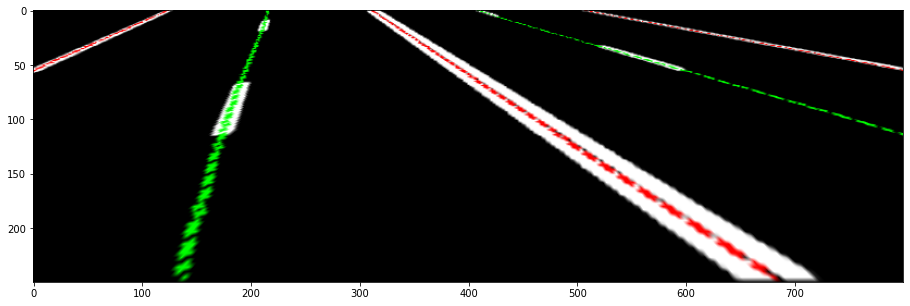

##############Pitcute№___590


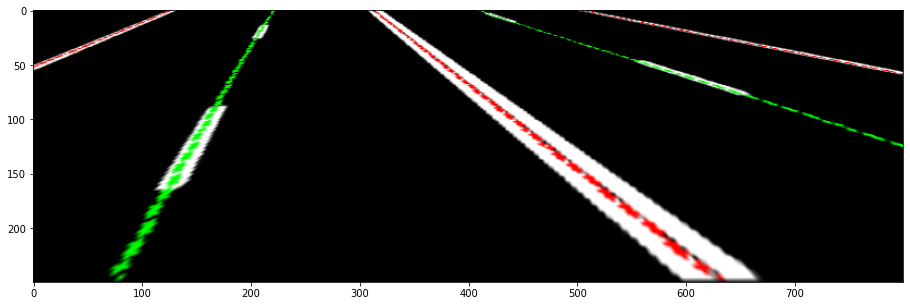

##############Pitcute№___591


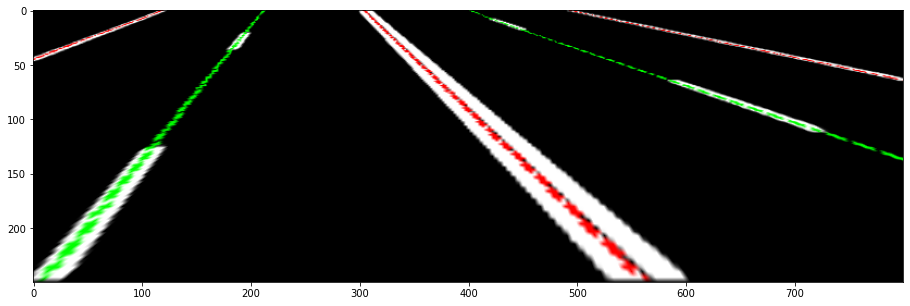

##############Pitcute№___592


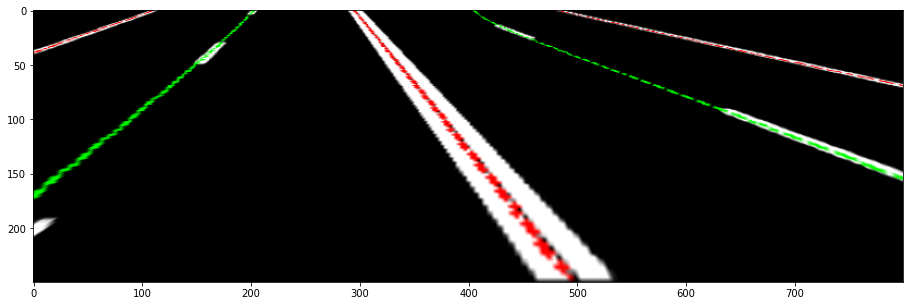

##############Pitcute№___593


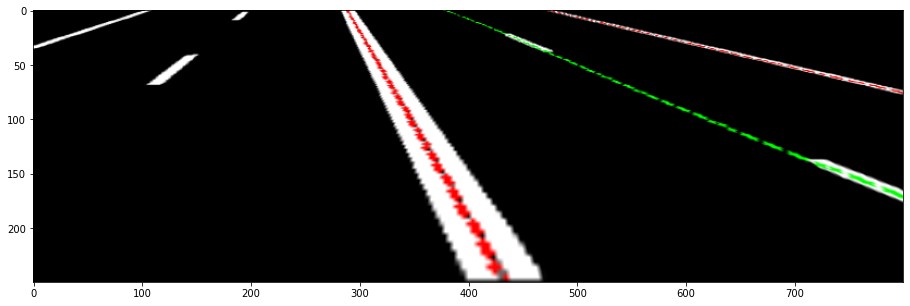

##############Pitcute№___594


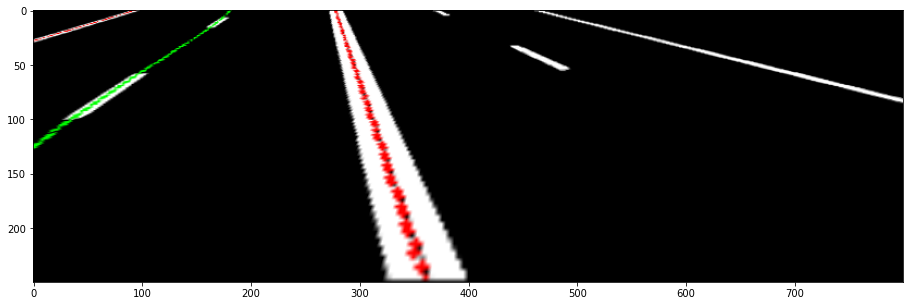

##############Pitcute№___595


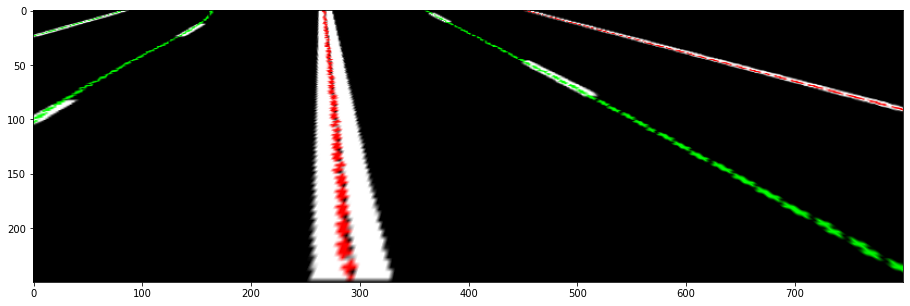

##############Pitcute№___596


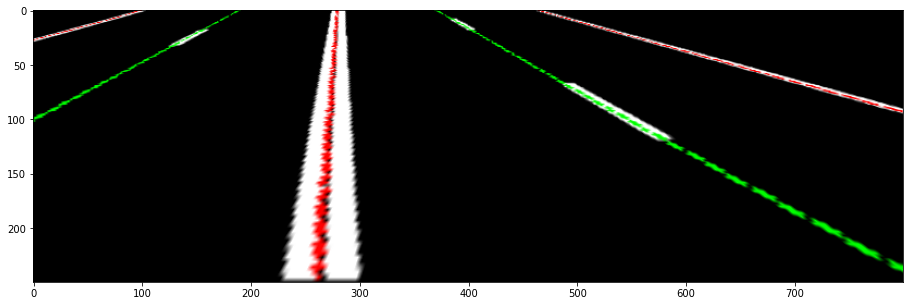

##############Pitcute№___597


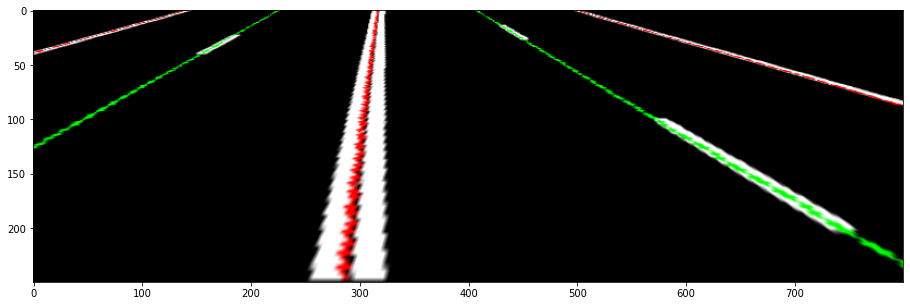

##############Pitcute№___598


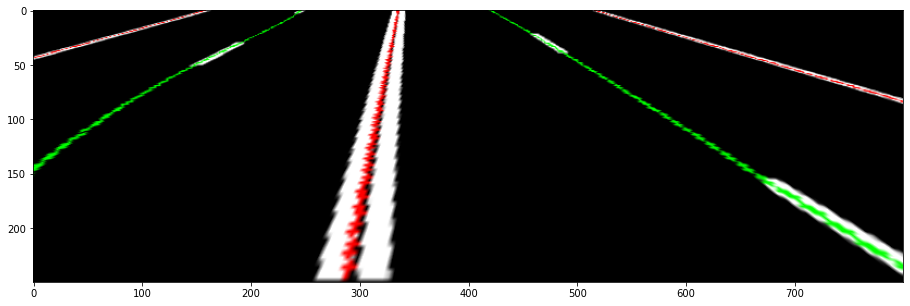

##############Pitcute№___599


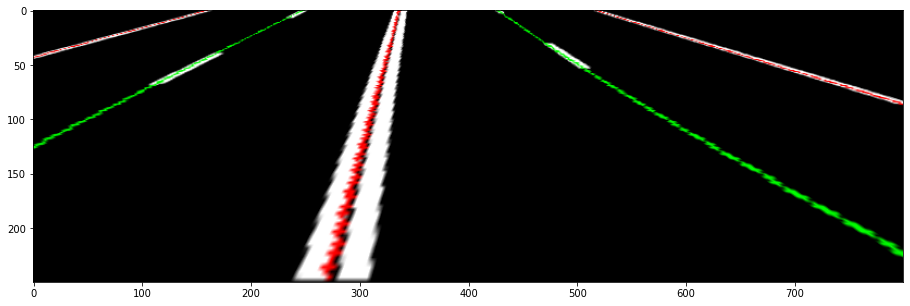

##############Pitcute№___600


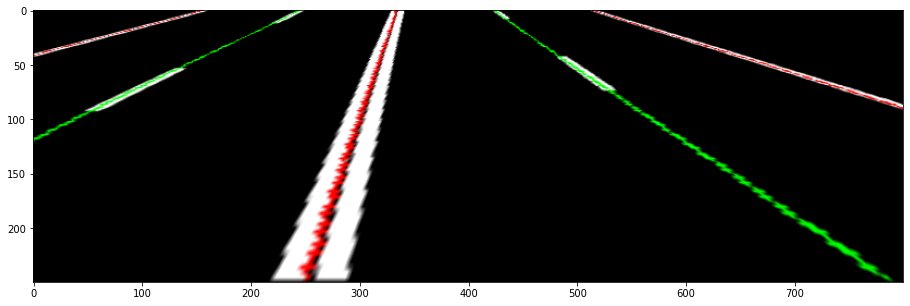

##############Pitcute№___601


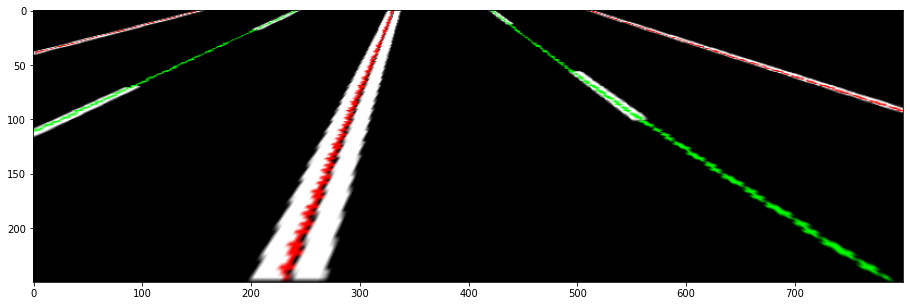

##############Pitcute№___602


C:\Users\Slava\AppData\Local\Temp\ipykernel_15964\1895345373.py:51: RuntimeWarning: invalid value encountered in double_scalars
  new_dist_r = [(dist_r[k] - mean_dir) / sqrt(var_dir) * sqrt(var_geo) + mean_geo for k in range(0,4) ]


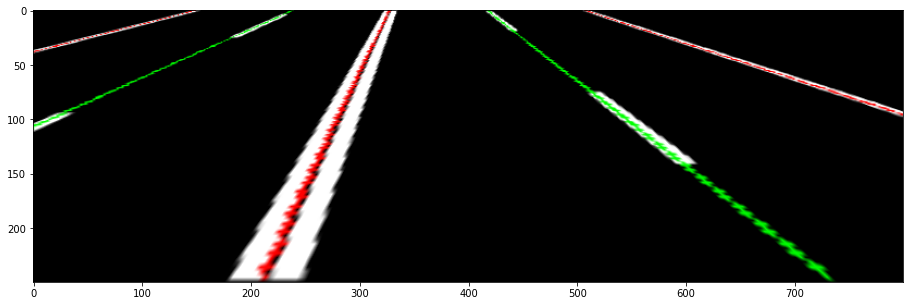

##############Pitcute№___603


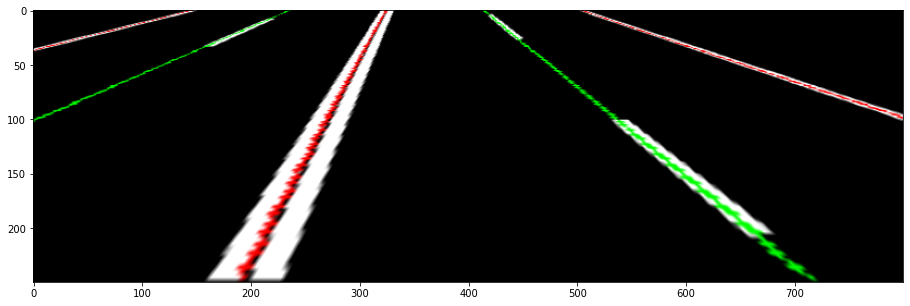

##############Pitcute№___604


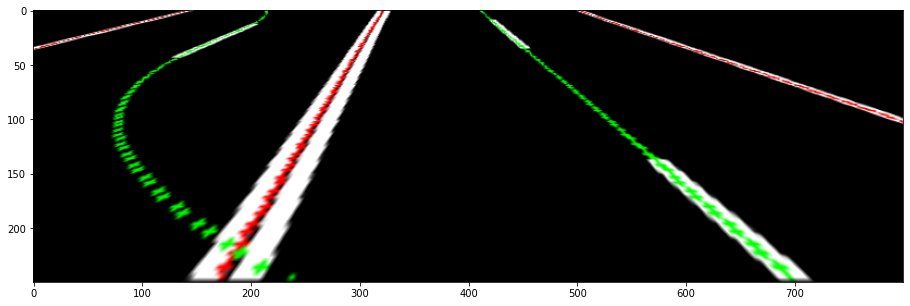

##############Pitcute№___605


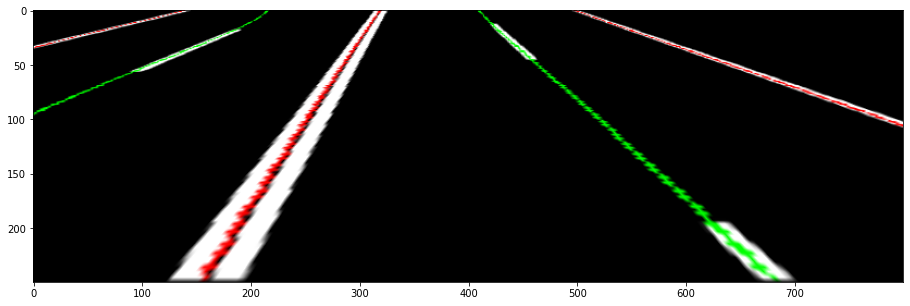

##############Pitcute№___606


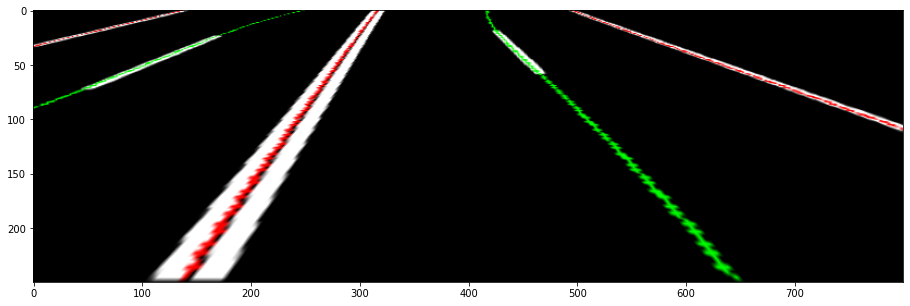

##############Pitcute№___607


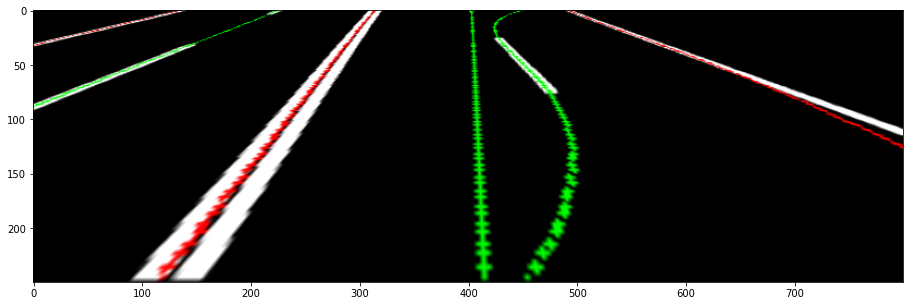

##############Pitcute№___608


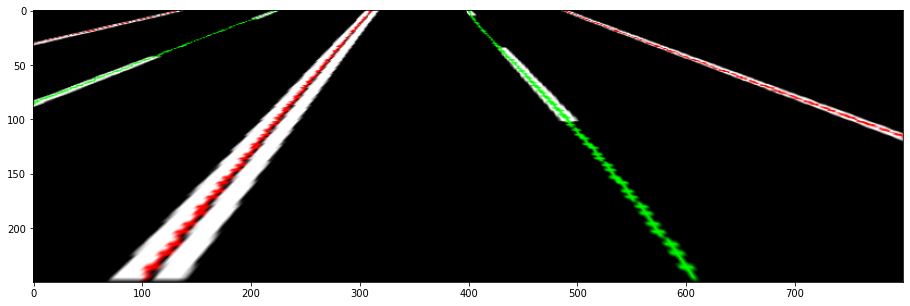

##############Pitcute№___609


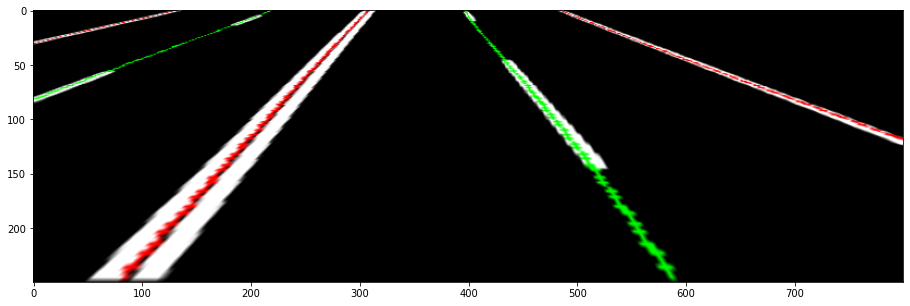

##############Pitcute№___610


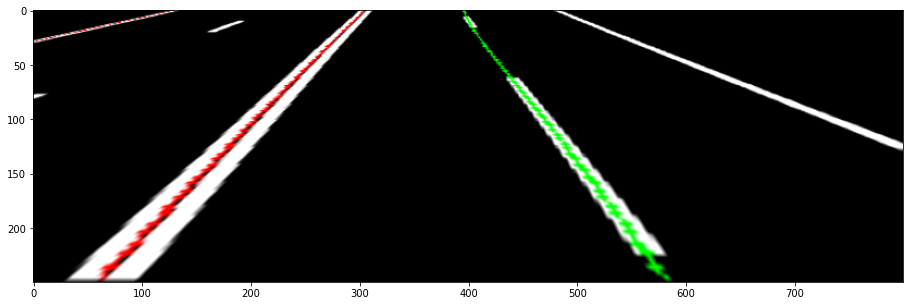

##############Pitcute№___611


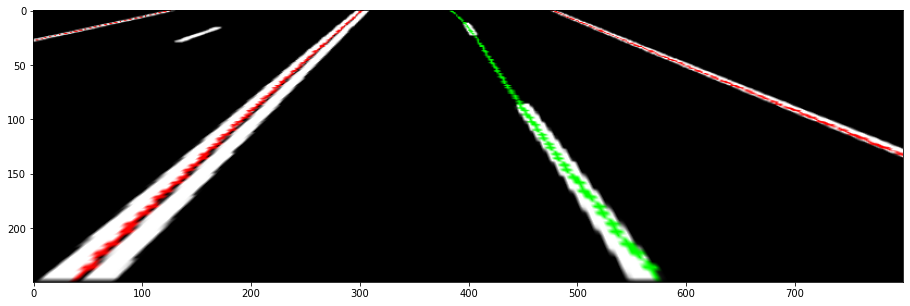

##############Pitcute№___612


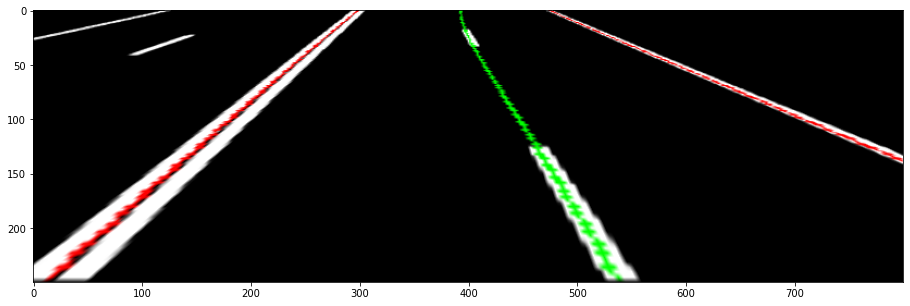

##############Pitcute№___613


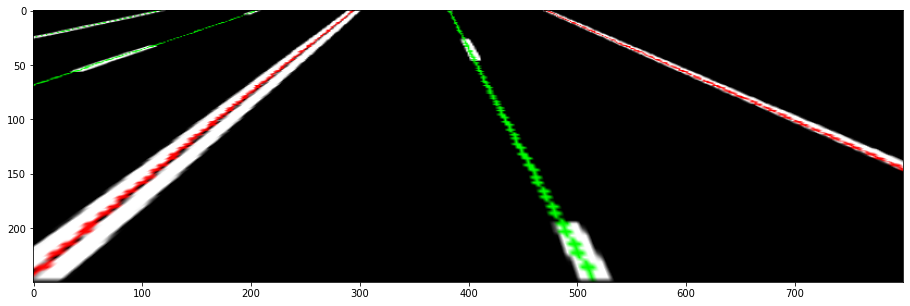

##############Pitcute№___614


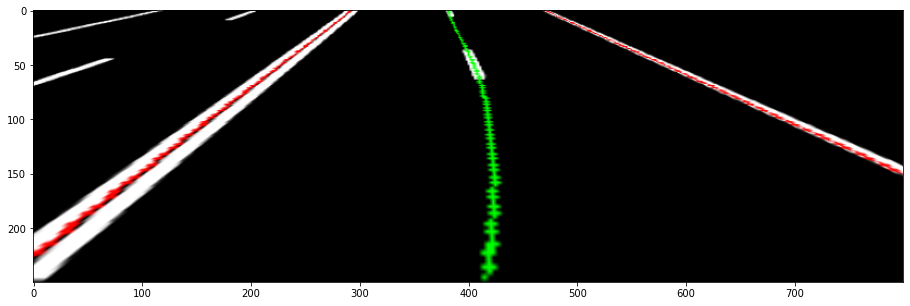

##############Pitcute№___615


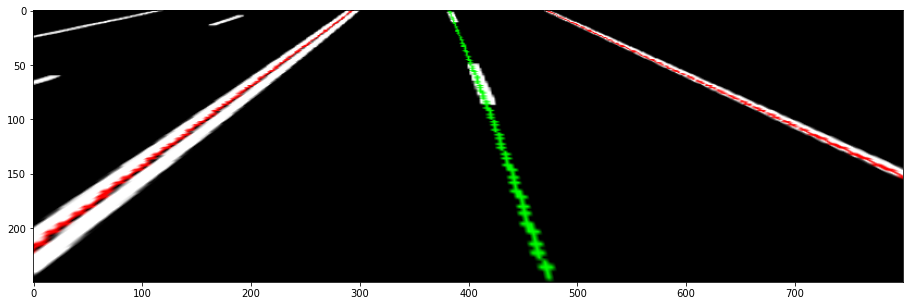

##############Pitcute№___616


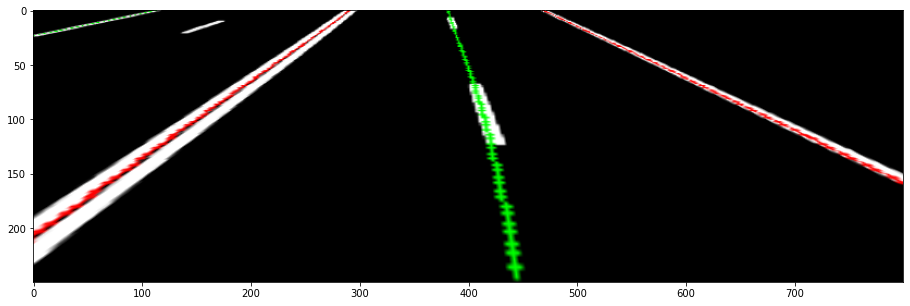

##############Pitcute№___617


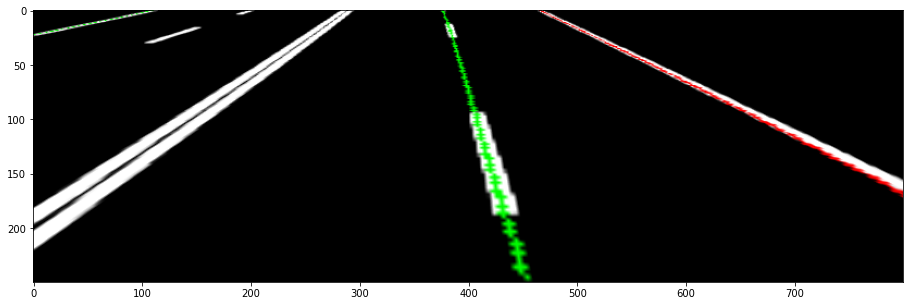

##############Pitcute№___618


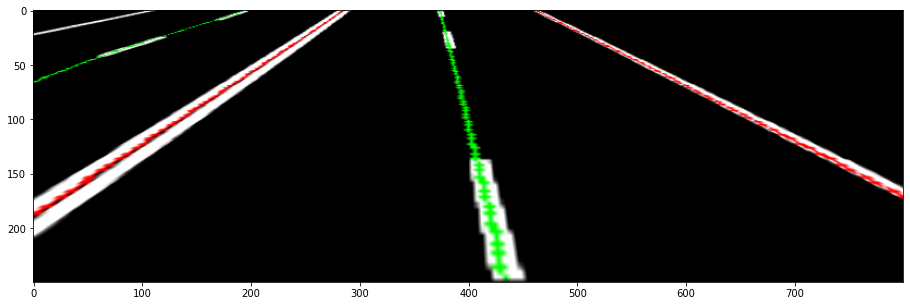

##############Pitcute№___619


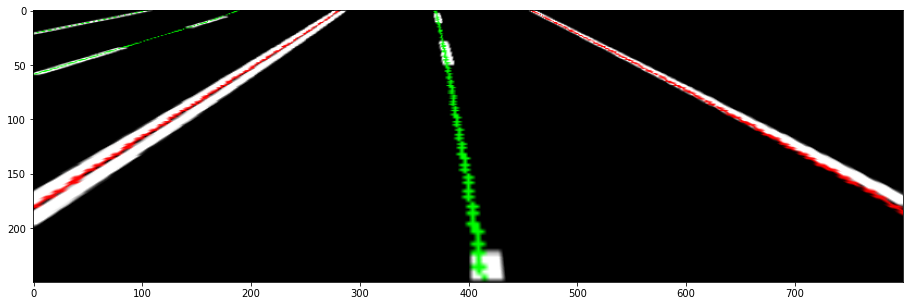

In [175]:
destination = "all"
for i in range(589,620):
    print("##############Pitcute№___" + str(i))
    
    img_primal = cv2.imread(os.path.join(destination,str(i) + ".png"))
    img_primal = (img_primal.sum(axis = 2) == 441).astype("uint8") * 255
    #plt.imshow(img_primal,cmap ="gray") # Show results
    #plt.show()
    
    warped_img, img, M, Minv = birdView(img_primal)
    
    CCWS = cv2.connectedComponentsWithStats(warped_img)
    (numLabels, labelssss, stats, centroids) = CCWS
    labels_index = list(range(1,numLabels))
    
    segments_linePoints = pointMeanPoints(CCWS,labels_index)
    
    segment_points = pointHeadAndTail2(CCWS,labels_index,segments_linePoints)
    
    connected_segments = linkSegments(labels_index, segment_points)
    
    segments_lineCoef = fitLines(CCWS,segments_linePoints)
    
    segments_classification = classification(CCWS,connected_segments,segments_lineCoef)
    
    turnPerspective(warped_img,segments_classification,segments_lineCoef,M,True)

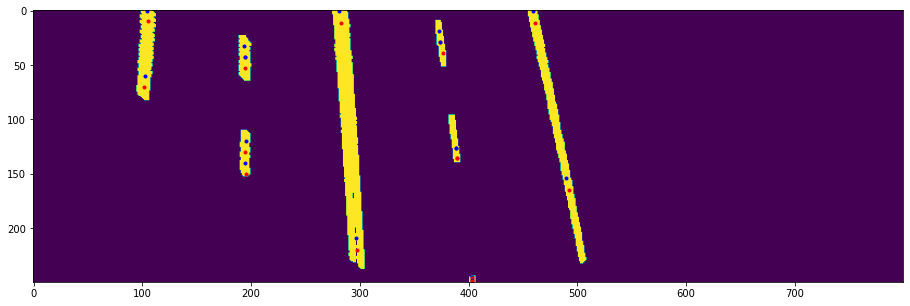

{1: [104, 0, 105, 10, 102, 60, 101, 70],
 2: [281, 0, 283, 11, 296, 209, 297, 220],
 3: [459, 0, 461, 11, 490, 154, 492, 165],
 4: [373, 19, 374, 29, 374, 29, 376, 39],
 5: [193, 33, 194, 43, 194, 43, 194, 53],
 6: [388, 126, 389, 136, 388, 126, 389, 136],
 7: [195, 120, 194, 130, 194, 140, 195, 150],
 8: [403, 245, 403, 246, 403, 248, 403, 249]}

In [176]:
pointHeadAndTail2(CCWS,labels_index,segments_linePoints,True)

In [177]:
labels_index

[1, 2, 3, 4, 5, 6, 7, 8]

In [178]:
IMAGE_H 

250

In [179]:
segments_lineCoef

[array([[-7.57575758e-06],
        [ 1.40692641e-04],
        [-1.90476190e-02],
        [ 1.04287879e+02]]),
 array([[ 5.41247208e-07],
        [-2.52785188e-04],
        [ 9.94247606e-02],
        [ 2.81397327e+02]]),
 array([[-1.28205411e-06],
        [ 2.69029931e-04],
        [ 1.91081479e-01],
        [ 4.58913507e+02]]),
 array([[-2.18403691e-08],
        [-5.65632091e-05],
        [ 1.48592365e-01],
        [ 3.70072915e+02]]),
 array([[ 6.53480351e-06],
        [-2.04329920e-03],
        [ 2.01496178e-01],
        [ 1.88365315e+02]])]

In [180]:
segments_classification

[1, 2, 2, 1, 1]